# Multi-Class Prediction of Obesity Risk 

This notebook builds classification models for Obesity Risk prediction using the Kaggle datasets where train.csv - the training dataset, and NObeyesdad is the categorical target. And test.csv is the test dataset and the objective is to predict the class of NObeyesdad for each row. 
  
The models include: 
- Multinomial Logistic Regression (MLR), 
- Linear Discriminant Analysis (LDA), 
- Naive Bayes (NBAY), and 
- Support Vector Machine (SVM) classifiers 

In [1]:
__author__ = "Will Hinton"
__email__ = "willhint@gmail.com"
__website__ = "whinton0.github.com/py"

## Load libraries and datasets
- Import necessary libraries for data processing, modeling, evaluation.

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Load the datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Display the first few rows
train_df.head()


,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


## Prepare the data, standardize features and define helper functions
- Combine train and test sets for consistent preprocessing 
- Encode categorical features using one-hot encoding 
- Split back into train and test sets 
- Encode target variable 
- Standardize features 
- Define helper functions for evaluation

In [3]:
# Combine train and test sets for consistent preprocessing
full_df = pd.concat([train_df.drop(columns=['NObeyesdad']), test_df], axis=0)

# Encode categorical features using one-hot encoding
categorical_cols = full_df.select_dtypes(include='object').columns
full_df_encoded = pd.get_dummies(full_df, columns=categorical_cols)

# Split back into train and test sets
X_train = full_df_encoded.iloc[:train_df.shape[0]]
X_test = full_df_encoded.iloc[train_df.shape[0]:]
y_train = train_df['NObeyesdad']
test_ids = test_df['id']

# Encode target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.drop(columns='id', errors='ignore'))
X_test_scaled = scaler.transform(X_test.drop(columns='id', errors='ignore'))


In [4]:
# Define helper functions for evaluation
def confusion_table(confusion_mtx, labels):
    return pd.DataFrame(confusion_mtx, index=[f"Actual_{l}" for l in labels], columns=[f"Pred_{l}" for l in labels])

def classifier_stats(confusion_mtx):
    correct = np.trace(confusion_mtx)
    total = np.sum(confusion_mtx)
    total_error_rate = 1 - (correct / total)
    return {
        'total_error_rate': total_error_rate,
    }


## Initialize, fit and evaluate models 
- Initialize classification models 
- Fit each model and evaluate 
- Convert results to DataFrame for comparison

In [5]:
# Initialize classification models
models = {
    'mlr': LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000),
    'lda': LinearDiscriminantAnalysis(),
    'nbay': GaussianNB(),
    'svm': SVC(kernel='linear', probability=True)  # using linear SVM for stability
}

results = {}
conf_matrices = {}

# Fit each model and evaluate
for name, model in models.items():
    model.fit(X_train_scaled, y_train_encoded)
    preds = model.predict(X_train_scaled)
    conf_mtx = confusion_matrix(y_train_encoded, preds)
    stats = classifier_stats(conf_mtx)
    results[name] = stats
    conf_matrices[name] = (conf_mtx, label_encoder.classes_)


In [6]:
# Convert results to DataFrame for comparison
results_df = pd.DataFrame(results).T
results_df


,total_error_rate
mlr,0.134406
lda,0.177811
nbay,0.411070
svm,0.127902


## Visualization

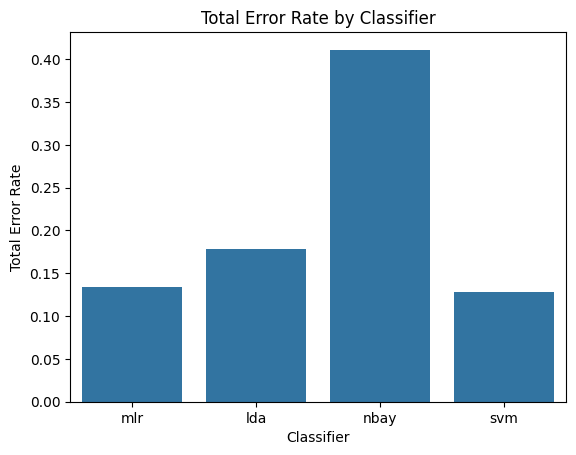

In [7]:
# Visualize total error rate
sns.barplot(x=results_df.index, y=results_df['total_error_rate'])
plt.title("Total Error Rate by Classifier")
plt.ylabel("Total Error Rate")
plt.xlabel("Classifier")
plt.show()


In [8]:
# Generate and save submission files for each model
submission_files = {}

for name, model in models.items():
    preds_test = model.predict(X_test_scaled)
    preds_labels = label_encoder.inverse_transform(preds_test)

    submission_df = pd.DataFrame({
        'id': test_ids,
        'NObeyesdad': preds_labels
    })

    filename = f"submission_{name}.csv"
    submission_df.to_csv(filename, index=False)
    submission_files[name] = filename

submission_files


{'mlr': 'submission_mlr.csv',
 'lda': 'submission_lda.csv',
 'nbay': 'submission_nbay.csv',
 'svm': 'submission_svm.csv'}